### Introduction

Systems able to recognize sounds directly from audio recordings are widely applicable. In this project,
you’ll attempt to create an audio tagging system by extracting audio clip image representations and then
using computer vision-based classification models. You can consider constructing your system using a
relatively large-scale competition data set and then evaluate it on its ability to recognize and distinguish more specialized sounds on locally generated recordings.

### Goals

1. Investigate and construct models for automatic audio tagging of noisy recordings.
2. Adapt this to smaller data sets of audio recordings, either by using a setup motivated by your
above findings or by transfer learning.
3. Construct an audio tagging application.

### Methods and materials

To achieve Goal 1 of the project, you can, for example, use the FSDKaggle2018 used in the Freesound
General-Purpose Audio Tagging Challenge on Kaggle. There are 41 categories of audio clips, and the
goal is to classify each clip. For the second objective, you can look for a data set on your own or
construct one yourself.

As part of the project, you should investigate ways to do data augmentation for audio.
You’ll make use of a variety of Python audio libraries, e.g., librosa. You should also look into fastxtend, a library built on top of fastai. To construct the application, you’re free to use any solution you know or want to investigate. A natural starting point is the deployment solutions used in the fastai course.

Consider not converting audio to images but instead setting up an audio classification framework that
operates on audio representations of the data.

In [1]:
from fastai.vision.all import *
import pandas as pd
from pathlib import Path

# Load the labels from the CSV file into a DataFrame
labels_csv_path = '/kaggle/input/audio-samples/FSDKaggle2018.meta/FSDKaggle2018.meta/train_post_competition.csv'
df_labels = pd.read_csv(labels_csv_path)

# Create a dictionary mapping filenames (without extension) to labels
labels_dict = pd.Series(df_labels.label.values, index=df_labels.fname.apply(lambda x: Path(x).stem)).to_dict()

# Define a function to get labels using the dictionary
def get_label(file_path):
    # Extract the filename without extension from the given file path
    file_stem = Path(file_path).stem
    # Return the label from the dictionary
    return labels_dict[file_stem]

In [2]:
# Define DataBlock
spectrogram_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=get_label,
    item_tfms=Resize(224)
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 156MB/s]


SuggestedLRs(valley=0.0014454397605732083)

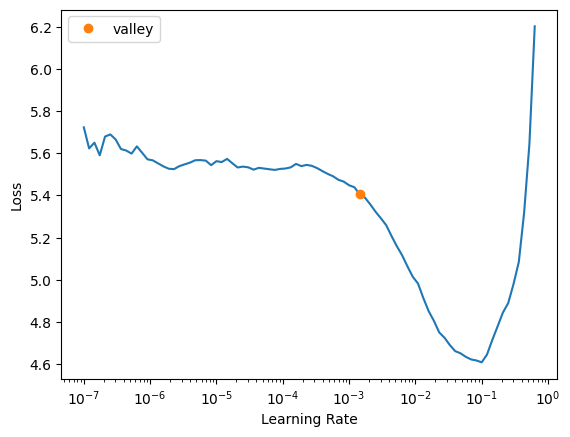

In [3]:
# Point to the path where train images are stored
path = Path('/kaggle/input/spectogramszip/Spectograms')

# Create the DataLoaders
dls = spectrogram_block.dataloaders(path, bs=64)

# Create a learner with a pre-trained model
learn = vision_learner(dls, resnet34, metrics=accuracy)

# Find an appropriate learning rate
learn.lr_find()

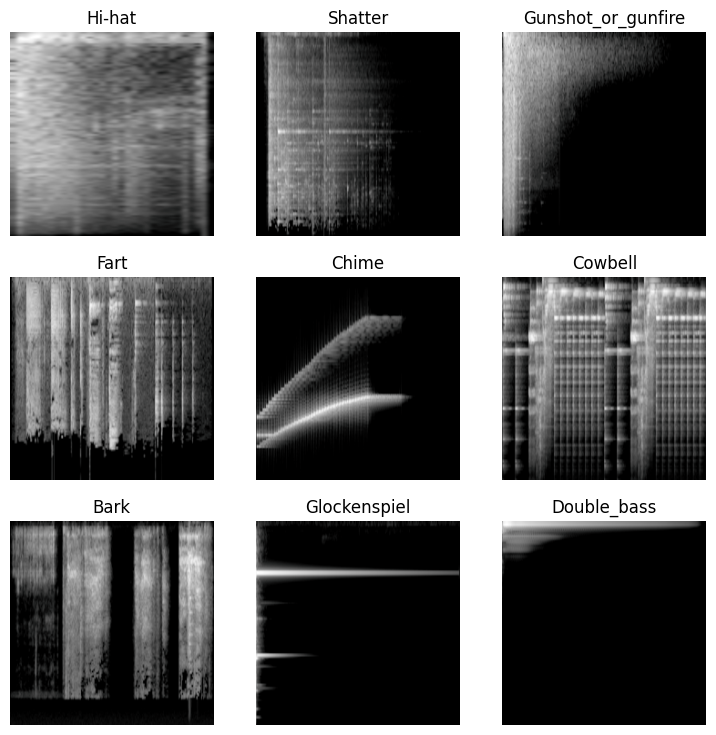

In [8]:
dls.show_batch()

In [6]:
# Train the model
learn.fit_one_cycle(5, 0.0014454397605732083)

epoch,train_loss,valid_loss,accuracy,time
0,3.513581,1.956987,0.474129,00:23
1,2.044720,1.392656,0.617740,00:22
2,1.359283,1.219133,0.678986,00:22
3,1.063385,1.126780,0.696410,00:21
4,0.881481,1.121685,0.695882,00:20


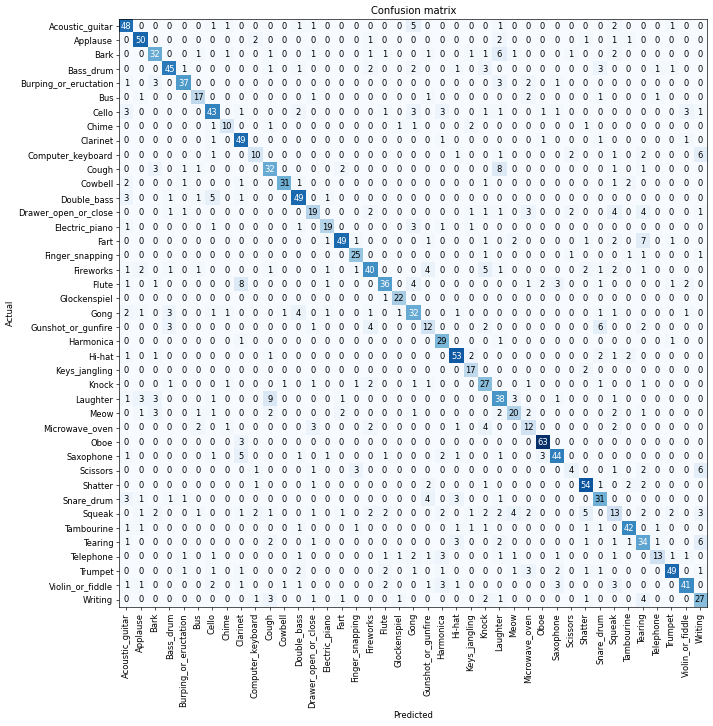

In [9]:
# Create an interpretation object
interp = ClassificationInterpretation.from_learner(learn)

# Plot the confusion matrix
interp.plot_confusion_matrix(figsize=(12, 12), dpi=60)